A particle moves in the square $[-1,1]^2$. It controls its acceleration on $x$ and $y$ axis (between -1 and 1). It cannot go faster than -1 or 1. 

It gets reward 1 if it reaches a givne zone

its actions are a bit noisy

The policy is greedy wrt Q

In [1]:
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
from utils import variable, moving_avg
from random import random
from torch.nn import LeakyReLU, ReLU, Linear, BatchNorm1d as BN
import torch.nn
from icnn import clip_gradients, ICNNBN, update_parameters_lag, loss_beyond_RMAX, get_q_target_q_target
import torch as t
import math
from moving_particle import Agent, create_dataset, argmax, clip
from replay_buffer import PrioritizedReplayBuffer
from copy import deepcopy

$$v(t+1) = v(t) + a(t)dt$$
$$x(t+1) = x(t) + v(t)dt$$


# Get data

In [2]:
dataset = create_dataset(5000, 100, lambda x,y,ax,ay: 2.25*(x**2+y**2 <= .5**2) -(x**2+y**2 - .5**2) - ax**2 - ay**2, lambda x,y: x**2+y**2 <= .5**2)
idx = list(set([d[0] for d in dataset]))

In [42]:
len(dataset)

137729

Plot an episode. It starts at the green dot and ends at the red dot. The blue circle is the terminal zone. Once there, the agent gets a +1 reward

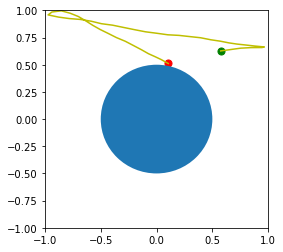

In [43]:
n = idx[152]
plt.rcParams['figure.figsize'] = (4,4)
x = [d[1][0] for d in dataset if d[0] == n]
y = [d[1][1] for d in dataset if d[0] == n]
circle = plt.Circle((0,0), radius=.5)
plt.gcf().gca().add_artist(circle)
plt.scatter(x[0],y[0],s=50,c='g')
plt.scatter(x[-1],y[-1],s=50,c='r')
plt.plot(x,y,c='y')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

# Get model

In [61]:
qs = ICNNBN(2, 20, 4, gain=math.sqrt(2/1.01), activation=LeakyReLU(.01))
qe = deepcopy(qs)
qe.eval()
print()

In [62]:
print('#params: %s' % np.sum([np.prod(p.data.numpy().shape) for p in qs.parameters()]))

#params: 1281


Observe model output with random weights

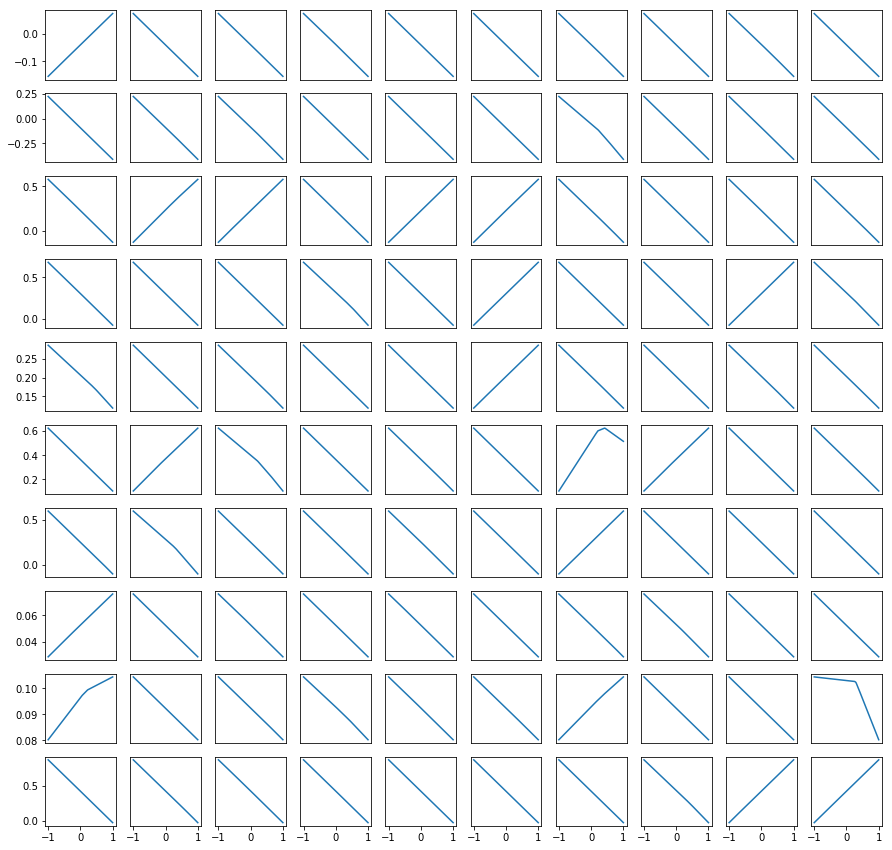

In [63]:
plt.rcParams['figure.figsize'] = (15,15)
fig, axes = plt.subplots(10,10)
qs.eval()
a, b = -1,1
for i in range(10):
    for j in range(10):
        state = variable(np.concatenate(100*[np.random.uniform(-1,1,size=(1,4))], 0)).float()
        actions = variable(np.array([[0.,a] for a in np.linspace(a,b,100)])).float()
        Qvalues = qs.forward(state, actions).data.numpy()
        axes[i,j].plot(np.linspace(a,b,100), Qvalues)
        if i<9:
            axes[i,j].get_xaxis().set_visible(False)
        if j>0:
            axes[i,j].get_yaxis().set_visible(False)
plt.show()
qs.train()
print()

Create memory

In [64]:
memory = PrioritizedReplayBuffer(150000, .6)
for idx,s,a,r,s_,done in dataset:
    memory.add(*(np.array(s),np.array(list(a)),np.array([r]),np.array(s_),np.array([done])))

# Train

In [65]:
learning_rate = 1e-3
optimizer = t.optim.Adam(qs.parameters(), lr=learning_rate, weight_decay=1e-5)

In [66]:
# monitoring
losses = []
td_errors = []
test_td_errors = []
test_average_q_pred = []
test_max_q_pred = []
test_min_q_pred = []
average_q_pred = []
average_q_target = []
max_q_pred = []
min_q_pred = []
max_q_target = []
min_q_target = []
average_ax = []
average_ay = []

In [67]:
def loss_beyond_RMAX(x, RMIN, RMAX):
    return (x > RMAX).float()*(x - RMAX)**2 + (x < RMIN).float()*(x - RMIN)**2

250 steps seen in 16.479514837265015


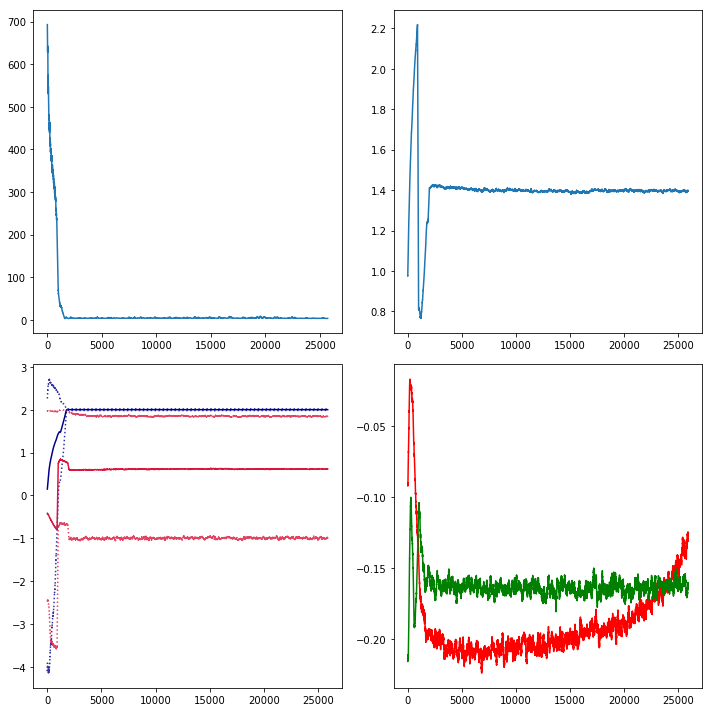

KeyboardInterrupt: 

In [68]:
from random import random
from time import time

plt.rcParams['figure.figsize'] = (10,10)

batch_size = 256
global_step = -1
RMAX = 2
RMIN = -7/4 - 2  # full acc in corner
tau = 1e-2
c = 1e5
max_steps_a = 10
gamma = .99
max_steps_beta = 100000
beta0 = .9
beta = lambda t: (t<max_steps_beta)*(beta0 + t*(1-beta0)/max_steps_beta) + (t>=max_steps_beta)*1.

while True:
    global_step += 1
    
    # sample
    s,a,r,s_,done,w,idx = memory.sample(batch_size, beta(global_step))
    states = variable(s)
    actions = variable(a)
    rewards = variable(r)
    next_states = variable(s_)
    weights = variable(w).squeeze()
    
    # init grad
    optimizer.zero_grad()

    # Compute loss
    pred = qs.forward(states,actions).squeeze()  # Q(s, a)

    target, max_actions = get_q_target(qs, qe, next_states, rewards, batch_size, done, min0=-1, max0=1, min1=-1, max1=1, gamma=gamma, max_steps_a=max_steps_a) # r + g * max_a' Q(s', a')
    target = clip(target.squeeze(), RMIN, RMAX)

    loss = (pred-target)**2
    loss = loss*weights  # multiplication by the PER coefficients
    loss = t.mean(loss) + c*t.mean(loss_beyond_RMAX(pred, RMIN, RMAX))

    # Update priorities
    td_error = t.abs(pred-target)+1e-2
    memory.update_priorities(idx, td_error.data.numpy())

    # Monitoring
    losses.append(loss.data.numpy()[0])
    td_errors.append(td_error.data.numpy().mean())
    average_q_pred.append(t.mean(pred).squeeze().data.numpy()[0])
    max_q_pred.append(t.max(pred).squeeze().data.numpy()[0])
    min_q_pred.append(t.min(pred).squeeze().data.numpy()[0])
    average_q_target.append(t.mean(target).squeeze().data.numpy()[0])
    max_q_target.append(t.max(target).squeeze().data.numpy()[0])
    min_q_target.append(t.min(target).squeeze().data.numpy()[0])
    average_a = max_actions.mean(0)
    max_a = max_actions.max(0)
    min_a = max_actions.min(0)
    average_ax.append(average_a[0])
    average_ay.append(average_a[1])
    
    # Compute gradients and update weights of the selection network
    loss.backward()
    clip_gradients(qs, 10)
    optimizer.step()

    # update parameters of the evaluation network. Its weights lag behind
    if global_step % 1000 == 0:
        qe = deepcopy(qs)
        qe.eval()
#     update_parameters_lag(qs, qe, tau)

    # PLOT
    if global_step % 250 == 0:
        display.clear_output(wait=True)
        try:
            print('250 steps seen in %s' % str(time()-t0))
        except:
            t0 = time()
        t0 = time()

        fig, axes = plt.subplots(2, 2)
        # td error
        axes[0,0].plot(moving_avg(losses)[200:])
        axes[0,1].plot(moving_avg(td_errors))
        # Q values (target and pred)
        axes[1,0].plot(moving_avg(average_q_pred), label='avg pred', c='darkblue')
        axes[1,0].plot(moving_avg(min_q_pred), label='min pred', c='darkblue', alpha=.8,linestyle=':')
        axes[1,0].plot(moving_avg(max_q_pred), label='max pred', c='darkblue', alpha=.8,linestyle=':')
        axes[1,0].plot(moving_avg(average_q_target), label='avg target', c='crimson')
        axes[1,0].plot(moving_avg(min_q_target), label='min target', c='crimson', alpha=.8,linestyle=':')
        axes[1,0].plot(moving_avg(max_q_target), label='max target', c='crimson', alpha=.8,linestyle=':')
        axes[1,1].plot(moving_avg(average_ax), label='ax', c='r')
        axes[1,1].plot(moving_avg(average_ay), label='ax', c='g')
        
        plt.tight_layout()
        plt.show()

# See policy

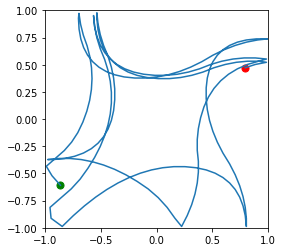

In [69]:
plt.rcParams['figure.figsize'] = (4,4)
qs.eval()
n_steps = 200
x0 = 2*random()-1
y0= 2*random()-1
vx0 = 2*random()-1
vy0 = 2*random()-1
agent = Agent(x0,y0,vx0,vy0, lambda x,y,ax,ay: -(x**2+y**2 - .5**2) - ax**2 - ay**2, lambda x,y: x**2+y**2 <= .5**2)
states = []
actions = []
for _ in range(n_steps):
    s = agent.observe()
    states.append(s)
    ss = variable(s).view(1,-1)
    a = argmax(qs, ss)
    ax, ay = a.data.numpy().tolist()[0]
    actions.append((ax,ay))
    
    ax = 1. if ax > 1 else ax
    ax = -1. if ax < -1 else ax
    ay = 1. if ay > 1 else ay
    ay = -1. if ay < -1 else ay
    
    agent.move(ax,ay)

x = [d[0] for d in states]
y = [d[1] for d in states]
plt.scatter(x[0], y[0], s=50, c='g')
plt.scatter(x[-1], y[-1], s=50, c='r')
plt.plot(x,y)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [70]:
actions

[(-1.100000023841858, -1.100000023841858),
 (-1.100000023841858, -1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (-1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 (1.100000023841858, 1.100000023841858),
 

In [54]:
qs(states,actions)

AttributeError: 'list' object has no attribute 'dim'

In [25]:
qs(t.cat(100*[ss]), variable(np.array([[0, aa] for aa in np.linspace(-1,1,100)])).view(-1,2))

Variable containing:
1.00000e-03 *
  4.1994
  4.1421
  4.0849
  4.0277
  3.9704
  3.9132
  3.8560
  3.7987
  3.7415
  3.6842
  3.6270
  3.5698
  3.5125
  3.4553
  3.3981
  3.3408
  3.2836
  3.2263
  3.1691
  3.1119
  3.0546
  2.9974
  2.9402
  2.8829
  2.8257
  2.7684
  2.7112
  2.6540
  2.5967
  2.5395
  2.4823
  2.4250
  2.3678
  2.3105
  2.2533
  2.1961
  2.1388
  2.0816
  2.0244
  1.9671
  1.9099
  1.8526
  1.7954
  1.7382
  1.6809
  1.6237
  1.5665
  1.5092
  1.4520
  1.3947
  1.3375
  1.2803
  1.2230
  1.1658
  1.1085
  1.0513
  0.9941
  0.9368
  0.8796
  0.8224
  0.7651
  0.7079
  0.6506
  0.5934
  0.5362
  0.4789
  0.4217
  0.3645
  0.3072
  0.2500
  0.1927
  0.1355
  0.0783
  0.0210
 -0.0362
 -0.0934
 -0.1507
 -0.2079
 -0.2652
 -0.3224
 -0.3796
 -0.4369
 -0.4941
 -0.5513
 -0.6086
 -0.6658
 -0.7231
 -0.7803
 -0.8375
 -0.8948
 -0.9520
 -1.0092
 -1.0665
 -1.1237
 -1.1810
 -1.2382
 -1.2954
 -1.3527
 -1.4099
 -1.4671
[torch.FloatTensor of size 100x1]

In [55]:
s,a,r,s_,done,w,idx = memory.sample(batch_size, beta(global_step))
states = variable(s)
actions = variable(a)
rewards = variable(r)
next_states = variable(s_)
weights = variable(w).squeeze()

# Compute loss
pred = qs.forward(states,actions).squeeze()  # Q(s, a)


In [57]:
target, max_actions = get_q_target(qs, qe, next_states, rewards, batch_size, done, min0=-1, max0=1, min1=-1, max1=1, gamma=gamma, max_steps_a=max_steps_a) # r + g * max_a' Q(s', a')
# target = clip(target.squeeze(), RMIN, RMAX)


In [58]:
target

Variable containing:
  5.6220
  4.9165
  1.4240
  5.4900
  0.8955
  6.8356
  1.2029
  0.5137
  0.8301
  1.9329
  0.9731
  9.1838
  1.5243
  4.2615
 12.3011
  7.5629
  1.0601
  1.5309
  2.8037
  4.8660
  1.0616
  0.5391
 -1.0524
  2.6499
  0.6393
  1.9243
  1.5556
  0.0964
  3.9189
  1.8425
  1.1490
  2.4913
  1.8236
  1.5178
  1.7499
  1.4310
  3.8713
  0.2369
  3.3518
  2.3966
 12.2177
  1.6798
  8.3549
 30.1814
  1.7966
 21.6514
 15.8665
  2.3945
  1.3574
  1.2894
  0.5661
  1.1607
  3.7406
  1.3590
  0.9846
  1.2176
  1.6425
  8.4858
 10.1665
  5.6839
  2.6617
  3.3823
  4.1416
  1.0259
 18.2030
  3.3609
  3.5403
  0.6467
  4.2491
  1.2340
  4.0070
 -0.0398
  9.1927
  1.5953
  0.8148
  6.2283
 14.5235
 16.5732
  0.8734
  1.8240
 11.3359
 11.2980
  9.1518
  0.3357
  4.0460
  0.6339
  9.7677
  1.1796
  0.8900
 12.6773
 25.1353
  0.9995
  1.1186
  9.7529
  1.2371
  1.4781
  5.4066
  1.3065
  0.2099
  6.8369
  0.5048
 16.6799
  1.8191
  1.2168
  1.8862
  1.5029
  0.4222
  1.9668
 12.749

In [59]:
clip(target.squeeze(), RMIN, RMAX)

Variable containing:
 2.0000
 2.0000
 1.4240
 2.0000
 0.8955
 2.0000
 1.2029
 0.5137
 0.8301
 1.9329
 0.9731
 2.0000
 1.5243
 2.0000
 2.0000
 2.0000
 1.0601
 1.5309
 2.0000
 2.0000
 1.0616
 0.5391
-1.0524
 2.0000
 0.6393
 1.9243
 1.5556
 0.0964
 2.0000
 1.8425
 1.1490
 2.0000
 1.8236
 1.5178
 1.7499
 1.4310
 2.0000
 0.2369
 2.0000
 2.0000
 2.0000
 1.6798
 2.0000
 2.0000
 1.7966
 2.0000
 2.0000
 2.0000
 1.3574
 1.2894
 0.5661
 1.1607
 2.0000
 1.3590
 0.9846
 1.2176
 1.6425
 2.0000
 2.0000
 2.0000
 2.0000
 2.0000
 2.0000
 1.0259
 2.0000
 2.0000
 2.0000
 0.6467
 2.0000
 1.2340
 2.0000
-0.0398
 2.0000
 1.5953
 0.8148
 2.0000
 2.0000
 2.0000
 0.8734
 1.8240
 2.0000
 2.0000
 2.0000
 0.3357
 2.0000
 0.6339
 2.0000
 1.1796
 0.8900
 2.0000
 2.0000
 0.9995
 1.1186
 2.0000
 1.2371
 1.4781
 2.0000
 1.3065
 0.2099
 2.0000
 0.5048
 2.0000
 1.8191
 1.2168
 1.8862
 1.5029
 0.4222
 1.9668
 2.0000
 2.0000
 1.6123
 1.3316
 2.0000
 1.3305
 1.7577
 2.0000
 1.7060
 1.4274
 2.0000
 1.4892
 2.0000
 0.9095
 2.

In [28]:
sum([d[2] for d in dataset])

94

In [29]:
len(dataset)

11703